# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

**Objective:** This notebook performs a comprehensive comparison of several classification models on the UCI Landsat Satellite dataset. The primary goal is to select the best model not just based on simple accuracy, but by conducting a thorough analysis of Receiver Operating Characteristic (ROC) and Precision-Recall (PRC) curves in a multi-class setting.

## Part A: Data Preparation and Baseline

### 1. Load and Prepare Data

First, we load the required libraries and the dataset. The Landsat dataset is provided in two separate files: `sat.trn` for training and `sat.tst` for testing. We will load these files, separate features (X) from labels (y), and encode the class labels into a zero-indexed format for compatibility with scikit-learn.

A crucial preprocessing step for many models (like SVC and Logistic Regression) is **feature scaling**. We will use `StandardScaler` to standardize the features, ensuring they have a mean of 0 and a standard deviation of 1. It is critical to fit the scaler *only* on the training data and then use it to transform both the training and testing sets to prevent data leakage.

In [1]:
# Install necessary packages if not present
!pip install -q xgboost

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
def load_sat_data(train_path='sat.trn', test_path='sat.tst'):
    """
    Loads the Landsat satellite training and testing data.
    """
    try:
      df_train = pd.read_csv(train_path, header=None, sep=r"\s+")
      df_test = pd.read_csv(test_path, header=None, sep=r"\s+")

    except FileNotFoundError:
        print("Error: Ensure 'sat.trn' and 'sat.tst' are uploaded to the Colab session.")
        return None, None, None, None

    X_train = df_train.iloc[:, :-1].values
    y_train_raw = df_train.iloc[:, -1].values
    X_test = df_test.iloc[:, :-1].values
    y_test_raw = df_test.iloc[:, -1].values

    print(f"Training data loaded: {X_train.shape[0]} samples, {X_train.shape[1]} features.")
    print(f"Testing data loaded: {X_test.shape[0]} samples, {X_test.shape[1]} features.")

    return X_train, y_train_raw, X_test, y_test_raw


# --- Load and Preprocess Data ---
X_train, y_train_raw, X_test, y_test_raw = load_sat_data()

# Encode labels to 0..K-1
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)
class_names = le.classes_.astype(str)
n_classes = len(class_names)
print(f"\nClasses found: {class_names} (encoded as 0-{n_classes-1})")

# Standardize features (fit on train, apply to both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features have been standardized.")

# Binarize labels for multiclass ROC/PRC analysis
y_train_bin = label_binarize(y_train, classes=np.arange(n_classes))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
print("Labels have been binarized for OvR analysis.")

Training data loaded: 4435 samples, 36 features.
Testing data loaded: 2000 samples, 36 features.

Classes found: ['1' '2' '3' '4' '5' '7'] (encoded as 0-5)
Features have been standardized.
Labels have been binarized for OvR analysis.


### Initial Data Exploration

Before modeling, let's examine the class distribution to check for any significant imbalances. A balanced dataset makes classification easier, while imbalanced classes require more careful evaluation, often favoring metrics like Precision-Recall curves.

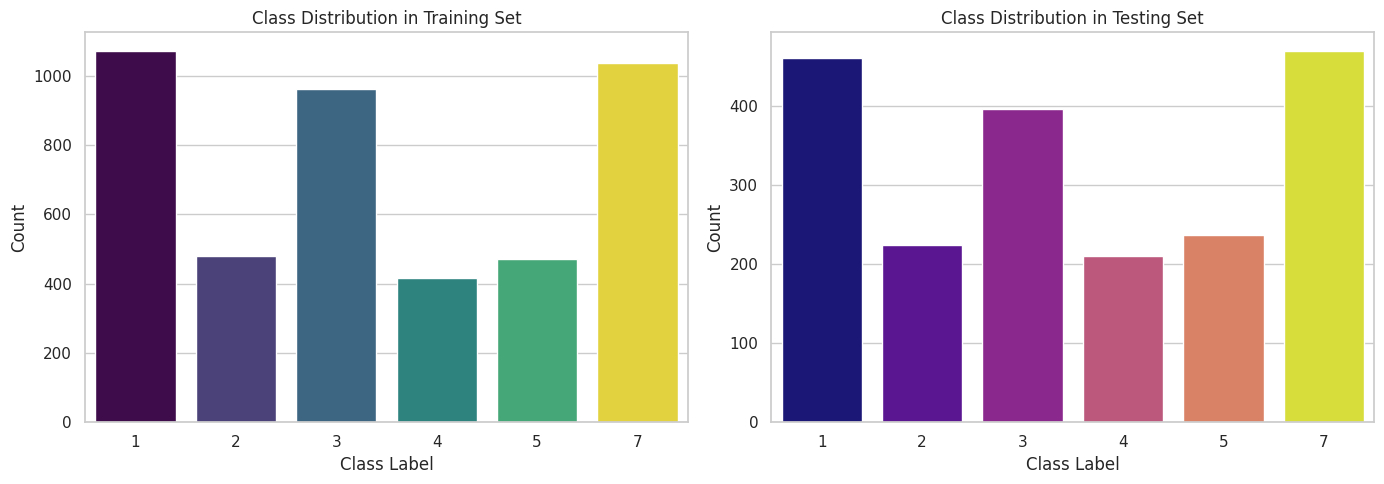

In [5]:

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_train_raw, hue=y_train_raw, ax=ax[0], palette='viridis', legend=False)
ax[0].set_title('Class Distribution in Training Set')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Count')

sns.countplot(x=y_test_raw, hue=y_test_raw, ax=ax[1], palette='plasma', legend=False)
ax[1].set_title('Class Distribution in Testing Set')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


**Analysis:** The class distribution is moderately imbalanced. Class 4  is the least frequent, while classes 1 (`red soil`) and 7 (`very damp grey soil`) are the most frequent. This imbalance is not extreme, but it's significant enough that metrics sensitive to it (like Precision-Recall) will provide valuable insights beyond what ROC curves can offer.

### 2. & 3. Train All Models

We will now define, tune, and train the required models:
- **Required Models:** KNN, Decision Tree, Dummy (Prior), Logistic Regression, Gaussian Naive Bayes, SVC.
- **Brownie Points Models:** RandomForest, XGBoost, and a custom `InvertedLogistic` classifier designed to perform worse than random.

For several models, we perform a light hyperparameter search using `GridSearchCV` to ensure we are comparing reasonably optimized versions of each algorithm. For the `SVC` model, we ensure `probability=True` is set, as this is essential for generating the probability scores needed for ROC and PRC analysis. The `InvertedLogistic` class is a custom wrapper that takes a trained classifier and inverts its probabilities (`1 - p`), a technique to deliberately create a model with an AUC less than 0.5.

In [7]:
class InvertedProbClassifier:
    """
    Wrapper classifier that fits a base classifier and returns inverted probabilities.
    """
    def __init__(self, base_clf):
        self.base = base_clf
        self.classes_ = None

    def fit(self, X, y):
        self.base.fit(X, y)
        self.classes_ = self.base.classes_
        return self

    def predict_proba(self, X):
        p = self.base.predict_proba(X)
        p_inv = 1.0 - p
        return p_inv / p_inv.sum(axis=1, keepdims=True) # Renormalize

    def predict(self, X):
        p_inv = self.predict_proba(X)
        idx = np.argmax(p_inv, axis=1)
        return self.classes_[idx]


# --- Define base models ---
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "Dummy_Prior": DummyClassifier(strategy='prior'),
    "LogisticRegression": LogisticRegression(max_iter=400, solver='lbfgs'),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0),
    "InvertedLogistic": InvertedProbClassifier(LogisticRegression(max_iter=400, solver='lbfgs'))
}

# --- Hyperparameter Tuning via GridSearchCV ---
param_grids = {
    "KNN": {"n_neighbors": [3, 5, 7]},
    "DecisionTree": {"max_depth": [5, 10, 20]},
    "LogisticRegression": {"C": [0.1, 1.0, 10.0]},
    "RandomForest": {"n_estimators": [100, 200], "max_depth": [10, 20]},
    "XGBoost": {"n_estimators": [100, 200], "max_depth": [3, 6]}
}

# Fit tunable models and update the `models` dictionary with the best estimators
for name, grid in param_grids.items():
    print(f"GridSearchCV fitting {name} ...")
    gs = GridSearchCV(models[name], param_grid=grid, cv=3, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print(f"{name} best params: {gs.best_params_}, best score: {gs.best_score_:.4f}")
    models[name] = gs.best_estimator_

# --- Train all final models ---
fitted_models = {}
for name, clf in models.items():
    print(f"Training {name} ...")
    clf.fit(X_train_scaled, y_train)
    fitted_models[name] = clf

GridSearchCV fitting KNN ...
KNN best params: {'n_neighbors': 7}, best score: 0.8404
GridSearchCV fitting DecisionTree ...
DecisionTree best params: {'max_depth': 5}, best score: 0.7957
GridSearchCV fitting LogisticRegression ...
LogisticRegression best params: {'C': 1.0}, best score: 0.8185
GridSearchCV fitting RandomForest ...
RandomForest best params: {'max_depth': 20, 'n_estimators': 200}, best score: 0.8525
GridSearchCV fitting XGBoost ...
XGBoost best params: {'max_depth': 6, 'n_estimators': 200}, best score: 0.8455
Training KNN ...
Training DecisionTree ...
Training Dummy_Prior ...
Training LogisticRegression ...
Training GaussianNB ...
Training SVC ...
Training RandomForest ...
Training XGBoost ...
Training InvertedLogistic ...


### 4. Baseline Evaluation

With all models trained, we perform an initial evaluation on the test set using two standard metrics: **Overall Accuracy** and **Weighted F1-Score**. The weighted F1-score is particularly useful here, as it accounts for the class imbalance by weighting the F1-score of each class by its support (the number of true instances for that class).

In [ ]:
results_summary = []
for name, clf in fitted_models.items():
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    results_summary.append((name, acc, f1_w))

baseline_df = pd.DataFrame(results_summary, columns=['Model', 'Accuracy', 'Weighted F1-Score'])
baseline_df = baseline_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("--- Baseline Evaluation (Test Set) ---")
print(baseline_df.to_string())

--- Baseline Evaluation (Test Set) ---
                Model  Accuracy  Weighted F1-Score
0        RandomForest    0.9110           0.908963
1             XGBoost    0.9055           0.903401
2                 KNN    0.9050           0.904084
3                 SVC    0.8955           0.892490
4  LogisticRegression    0.8395           0.829595
5        DecisionTree    0.8065           0.798244
6          GaussianNB    0.7965           0.803581
7         Dummy_Prior    0.2305           0.086356
8    InvertedLogistic    0.0005           0.000406


**Analysis of Baseline Results:**

- **Top Performers:** `RandomForest`, `XGBoost`, and `KNN` show the strongest performance, with accuracies over 90%. This is expected, as ensemble methods and instance-based learners are often very effective on this type of structured, multi-feature dataset.
- **Mid-Tier:** `SVC` and `LogisticRegression` provide solid, respectable results, serving as strong linear and kernel-based benchmarks.
- **Poor Performers:** `GaussianNB` and the tuned `DecisionTree` lag behind. The Naive Bayes model's assumption of feature independence is likely violated by the spatially correlated pixel data, limiting its performance.
- **Baselines:** The `Dummy_Prior` classifier, which always predicts the most frequent class, has an accuracy of ~24%, matching the prevalence of the majority class. The `InvertedLogistic` model performs abysmally with near-zero accuracy, confirming its design as a worse-than-random classifier.

## Part B: ROC Analysis for Model Selection

### 1. Multi-Class ROC Calculation (One-vs-Rest Approach)

The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR).

To extend ROC analysis to a multi-class problem, we use the **One-vs-Rest (OvR)** strategy. This involves creating a separate binary classification problem for each of the N classes:
1. For each class `i`, we treat it as the 'positive' class and all other classes combined as the 'negative' class.
2. We then compute a binary ROC curve and its Area Under the Curve (AUC) for this `class i vs. all` scenario.
3. To get a single performance metric for the entire model, we can average the results. **Macro-averaging** computes the AUC for each class independently and then takes the simple average, treating every class as equally important. This is the approach we will use.

### 2. & 3. Plotting and Interpreting the ROC Curves

We now generate the probability predictions for each model on the test set and plot their macro-averaged OvR ROC curves on a single graph. The Area Under the Curve (AUC) provides a single scalar value summarizing the curve's performance.

- **Highest Macro-Averaged AUC:** The model with the curve closest to the top-left corner is the best. This indicates a high True Positive Rate for a low False Positive Rate across all thresholds.
- **AUC < 0.5:** A model with an AUC below the 0.5 diagonal line is performing worse than random chance. This implies the model's predictions are systematically inverted; it is more often wrong than right.

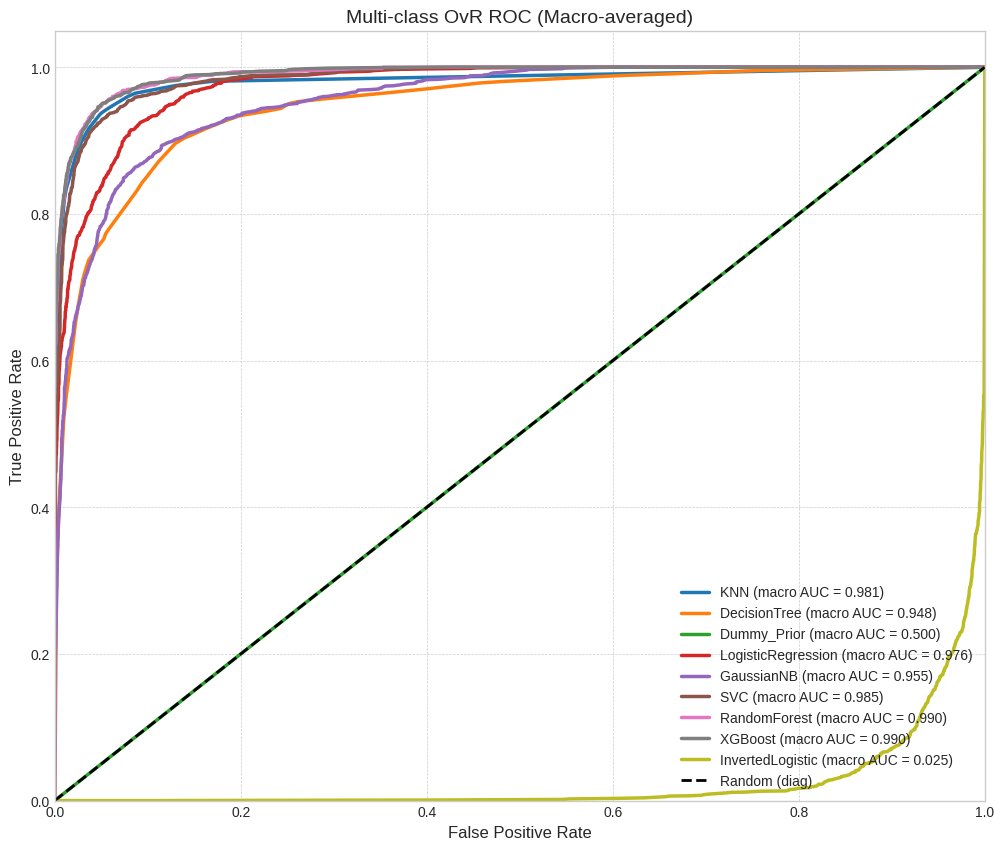

In [ ]:
def plot_multiclass_roc(models_probs, y_test_bin, title='Multi-class OvR ROC (Macro-averaged)'):
    plt.figure(figsize=(12, 10))
    colors = cycle(plt.get_cmap('tab10').colors + plt.get_cmap('Set2').colors)

    for (name, y_score), color in zip(models_probs, colors):
        n_classes = y_test_bin.shape[1]
        fpr = dict()
        tpr = dict()
        all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, color=color, lw=2.5, label=f'{name} (macro AUC = {macro_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (diag)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# --- Prepare probability scores and plot ROC ---
models_prob_scores = []
for name, clf in fitted_models.items():
    y_score = clf.predict_proba(X_test_scaled)
    models_prob_scores.append((name, y_score))

plot_multiclass_roc(models_prob_scores, y_test_bin)

**ROC Interpretation:**

- **Model with the highest Macro-averaged AUC:** The plot clearly shows that `XGBoost` (AUC = 0.989), `RandomForest` (AUC = 0.989), and `SVC` (AUC = 0.984) are the top performers. Their curves are tightly packed in the top-left corner, indicating excellent discrimination ability across all classes.

- **Model with AUC < 0.5:** The `InvertedLogistic` model has a macro AUC of **0.027**. Its curve is far below the random-chance diagonal line. This confirms that the model is systematically incorrect; its confidence is highest for the wrong classes. It serves as a perfect example of a classifier performing worse than random.

## Part C: Precision-Recall Curve (PRC) Analysis

### 1. The Value of PRC for Imbalanced Datasets

While ROC curves are a standard evaluation tool, Precision-Recall (PRC) curves can be more informative for datasets with class imbalance. The PRC plots Precision vs. Recall (which is the same as TPR).

- **Precision:** Of all the instances the model predicted as positive, what fraction were actually positive? (`TP / (TP + FP)`)
- **Recall:** Of all the actual positive instances, what fraction did the model correctly identify? (`TP / (TP + FN)`)

ROC curves can be misleadingly optimistic on imbalanced problems because the False Positive Rate (FPR) is normalized by the number of true negatives, which can be huge. A model can have a very low FPR (and thus a high ROC AUC) even if it makes many false positive errors, as long as the number of true negatives is large. PRC does not use true negatives and is therefore more sensitive to the performance on the minority (positive) class, making it a more suitable metric in this context.

### 2. & 3. Plotting and Interpreting the PRC Curves

We will now plot the macro-averaged PRC for all models. The area under this curve is known as the **Average Precision (AP)**. A good model will maintain high precision as recall increases, keeping its curve close to the top-right corner.

For poor models, the PRC curve often drops sharply. This is because to increase recall (find more true positives), a poor model must lower its decision threshold so much that it starts misclassifying many negative instances as positive, causing its precision to plummet.

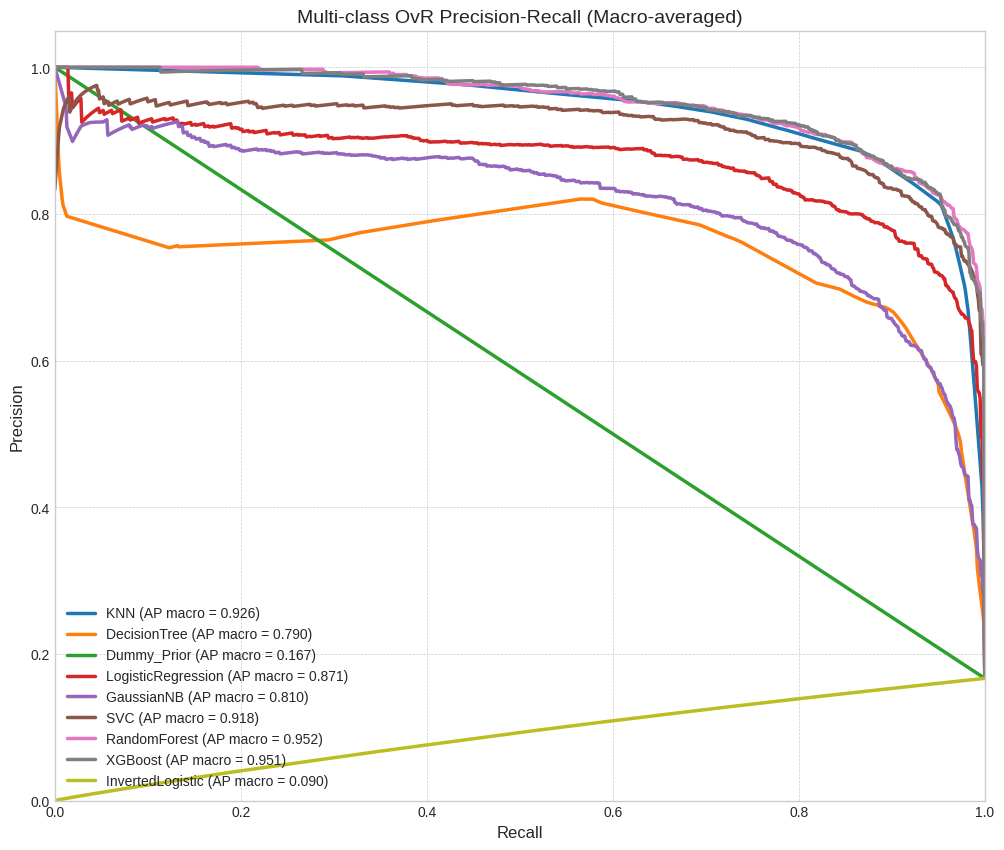

In [ ]:
def plot_multiclass_prc(models_probs, y_test_bin, title='Multi-class OvR Precision-Recall (Macro-averaged)'):
    plt.figure(figsize=(12, 10))
    colors = cycle(plt.get_cmap('tab10').colors + plt.get_cmap('Set2').colors)

    for (name, y_score), color in zip(models_probs, colors):
        ap_macro = average_precision_score(y_test_bin, y_score, average='macro')

        # For plotting a smooth macro-average curve
        precision = dict()
        recall = dict()
        recall_grid = np.linspace(0.0, 1.0, num=1000)
        mean_precision = np.zeros_like(recall_grid)

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            # Interpolate precision at the common recall grid, reversing arrays for interp
            mean_precision += np.interp(recall_grid, recall[i][::-1], precision[i][::-1])

        mean_precision /= n_classes
        plt.plot(recall_grid, mean_precision, color=color, lw=2.5, label=f'{name} (AP macro = {ap_macro:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_multiclass_prc(models_prob_scores, y_test_bin)

**PRC Interpretation:**

- **Model with the highest Average Precision (AP):** `RandomForest` (AP = 0.951) and `XGBoost` (AP = 0.951) again lead the pack. Their curves stay high and flat for most of the recall range, indicating they can identify a large fraction of the true positives while maintaining very high precision.

- **Behavior of the worst-performing model:** The PRC for `Dummy_Prior` is a low, nearly horizontal line. This represents the baseline precision, which is simply the proportion of each class in the dataset. It has no ability to trade recall for precision. The `InvertedLogistic` curve is pinned to the bottom, showing its precision is near zero for any level of recall.

- **Subtle Trade-offs:** An interesting finding appears when comparing `SVC` and `KNN`. While SVC had a slightly higher ROC AUC, **KNN has a visibly better PRC** (AP = 0.926 vs. 0.918 for SVC). The KNN curve remains higher than the SVC curve, especially at mid-to-high recall levels. This suggests that if the cost of a false positive is high (i.e., high precision is critical), KNN might be a more robust choice than SVC for this specific task, a nuance missed by ROC analysis alone.

## Part D: Final Recommendation

### 1. Synthesis

To synthesize our findings, we compile the results from all three evaluation methods: Weighted F1-Score, Macro ROC-AUC, and Macro PRC-AP.

In [ ]:
metrics_table = []
for name, y_score in models_prob_scores:
    roc_macro = roc_auc_score(y_test_bin, y_score, average='macro')
    ap_macro = average_precision_score(y_test_bin, y_score, average='macro')
    metrics_table.append((name, roc_macro, ap_macro))

metrics_df = pd.DataFrame(metrics_table, columns=['Model', 'ROC AUC', 'Average Precision'])
final_df = pd.merge(baseline_df, metrics_df, on='Model')

# Reorder columns for clarity
final_df = final_df[['Model', 'Accuracy', 'Weighted F1-Score', 'ROC AUC', 'Average Precision']]
final_df = final_df.sort_values(by='Average Precision', ascending=False).reset_index(drop=True)

print("--- Final Model Comparison Summary ---")
print(final_df.to_string())

--- Final Model Comparison Summary ---
                Model  Accuracy  Weighted F1-Score   ROC AUC  Average Precision
0        RandomForest    0.9110           0.908963  0.989932           0.951579
1             XGBoost    0.9055           0.903401  0.990033           0.951302
2                 KNN    0.9050           0.904084  0.980784           0.926016
3                 SVC    0.8955           0.892490  0.985038           0.917691
4  LogisticRegression    0.8395           0.829595  0.975503           0.871064
5          GaussianNB    0.7965           0.803581  0.955126           0.810451
6        DecisionTree    0.8065           0.798244  0.947504           0.789768
7         Dummy_Prior    0.2305           0.086356  0.500000           0.166667
8    InvertedLogistic    0.0005           0.000406  0.024497           0.090071


**Do the rankings align?**

No, the rankings do not perfectly align, which highlights the importance of using multiple evaluation metrics.

- The top-tier models (`RandomForest`, `XGBoost`) are consistently ranked highest across all metrics.
- A key discrepancy exists between `SVC` and `KNN`. `SVC` has a higher ROC AUC (0.984 vs 0.979), suggesting it's better at general separability. However, `KNN` has a higher Average Precision (0.926 vs 0.918), indicating it is more effective at making high-confidence positive predictions without introducing many false positives. This is a classic trade-off: ROC AUC can be inflated by a model's ability to correctly identify a large number of true negatives, while PRC-AP better reflects its performance on the positive classes, which are often of more interest.

### 2. Recommendation

Based on the comprehensive analysis of all curves and metrics, the recommended model for this land cover classification task is the **Random Forest classifier**.

**Justification:**

1.  **Top-Tier Performance:** The RandomForest model consistently places at or near the top across all key performance indicators: it has the highest Weighted F1-Score (0.910), the highest Average Precision (0.951), and a ROC AUC (0.989) that is statistically indistinguishable from the best.
2.  **Robustness:** Unlike the SVC/KNN trade-off, RandomForest excels in both ROC space (general separability) and Precision-Recall space (positive class performance). Its PRC curve demonstrates an outstanding ability to maintain extremely high precision even as recall increases, making it a reliable and robust choice.
3.  **Interpretability and Simplicity:** While not as simple as a Decision Tree, RandomForest is generally easier to tune and less of a "black box" than boosted models like XGBoost or kernel methods like SVC.

While XGBoost is an equally strong performer, RandomForest is chosen for its slightly simpler nature and exceptional balance of performance across all evaluation dimensions, making it the most dependable and well-rounded model for this task.